In [1]:
from matplotlib import pyplot as plt

## Functiosn


In [2]:
from Utilities import *
from Data.Boussineq_2D_Data import *
import torch
from torch.utils.data import DataLoader,Dataset
from functorch import jacrev,vmap,vjp
import numpy as np
from torch import tensor
from datetime import datetime
import csv
import time
import os

'''
Script to recreate HFM
'''

def aux_wrap(net):
    def aux_net(xyt):
        result = net(xyt)
        return result,result
    return aux_net
def get_conc_derivs(net,xyt,hes_vecs):
    '''
    Get the all the derivatives for the equations for Navier Stokes and Concentration Equations
    Assumes the NN Model maps: (x,y,t) --> (u,v,p,c)

    Uses Functorch a JAX like interface to get derivatives
    '''
    aux_net = aux_wrap(net)
    #Crazy One Functional liner gives returns (Jacobian,Hessian function, Network Evaluation) for input xyt = (x,y,t)
    jac,partial_hess,out = vjp(jacrev(aux_net,has_aux = True),xyt,has_aux = True)

    u,v,p,temp = out

    #Jacobian:
    ## x        y       t
    #u ux       uy      ut
    #v vx       vy      vt
    #p px       py      pt
    #c temp_x  temp_y   temp_t
    ux,uy,ut = jac[0,:]
    vx,vy,vt = jac[1,:]
    px,py    = jac[2,0:2]
    temp_x,temp_y,temp_t = jac[3,:]
    
    #The partial hess allows us to get the derivatives of specific elements in the Jacobian
    #Much more effecient than calulating entire hessian
    d2 = vmap(partial_hess)(hes_vecs)[0]

    #Second Order Terms
    uxx,uyy = d2[[0,1],[0,1]]
    vxx,vyy = d2[[2,3],[0,1]]
    temp_xx,temp_yy = d2[[4,5],[0,1]]

    return (p,px,py), (temp,temp_x,temp_y,temp_t,temp_xx,temp_yy),(u,ux,uy,ut,uxx,uyy),(v,vx,vy,vt,vxx,vyy) 
    
# Code for one epoch
def one_epoch(train_loader,net,optimizer,Re = 100, bouy = 100,alpha = 100, device = 'cpu',weights = None):
    vecs = torch.zeros((6,4,3))
    #These tensors allow us to effeciently get 2nd order derivatives without
    #Computing the entire Hessian
    #uxx uyy
    vecs[0,0,0] = 1
    vecs[1,0,1] = 1

    #vxx vyy
    vecs[2,1,0] = 1
    vecs[3,1,1] = 1

    #Cxx, Cyy
    vecs[4,3,0] = 1
    vecs[5,3,1] = 1
    vecs = vecs.to(device)


    if weights is None:
        weights = [1.]*6
    #Variables to keep track of total loss and individual losses (unweighted)
    running_loss = 0.
    indi_loss = torch.zeros(6)

    for data in train_loader:
        optimizer.zero_grad()
        
        xyt,u_data,v_data = data[0].to(device),data[1].to(device),data[2].to(device)
        (p,px,py), (temp,temp_x,temp_y,temp_t,temp_xx,temp_yy),(u,ux,uy,ut,uxx,uyy),(v,vx,vy,vt,vxx,vyy) = vmap(get_conc_derivs,(None,0,None))(net,xyt,vecs)
        #we output u,y,T-T0 as T-T0 scales to -1 and 1. We can recover original temp by adding T0

        #Boussineq stokes eq
        e1 = ut + u*ux+v*uy + px - 1/Re*(uxx + uyy) 
        #y direction has additional buoyancy term
        e2 = vt + vx*u +vy*v + py - 1/Re*(vxx+vyy) + bouy*(temp)
        #Incompress
        e3 = ux+vy
        #Concentration eq
        e4 = temp_t + (u*temp_x + v*temp_y) - alpha*(temp_xx+temp_yy)
        # Data Fitting
        e5 = u-u_data 
        e6 = v-v_data
        eq_s = [e1,e2,e3,e4,e5,e6]

        #Sum of MSE of each loss
        
        total_loss = sum([w*e.pow(2).mean() for w,e in zip(weights,eq_s)])
        
        #Get Gradients then update weights
        total_loss.backward()
        optimizer.step()
        
        #Loss Tracking
        running_loss += total_loss
        indi_loss += tensor([e.pow(2).mean() for e in eq_s])
        
    return running_loss ,indi_loss 

class Boussineq_Dataset(Dataset):
    def __init__(self,data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self,idx):
        data = self.data[idx,:]
        xyt = data[0:3]
        u = data[3]
        v = data[4]
        return xyt,u,v






In [3]:
def main(MAX_EPOCHS = 10_000,N_SAMPLE = None,batch_size = 10_000,MAX_HOUR_DURATION = 40,SAVE_PATH = 'Save/Boussineq'):
    if not os.path.exists(SAVE_PATH):
        os.mkdir(SAVE_PATH)
        print(f'Folder {SAVE_PATH} Created')

    #Set Network Up
    net = HFM_Net(3,4,10,50)
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    net.non_lin = torch.tanh

    net = net.to(device)

    #Data Wrangling see HFM_training data for how data works (from HFM paper)
    x_data,y_data,t_data,u_data,v_data,temp_data,p_data = np.moveaxis(get_boussineq_2D('Data/DHC_2D_Unsteady.dat',shuffle=False),0,-1)
    
    #Dimensional Scales
    RHO = 998
    L = 0.01
    U = 1e-3
    MU = 0.00959
    #For Temp inthis case leave as 1 
    T = 1 
    #Thermal Expansion
    BETA = 0.000228
    #Conductivity #specific Heat
    k,Cp = 0.606,4181
    alpha_star = k/(Cp*RHO)

    Re = RHO*U*L/MU
    bouy = -9.81*L*BETA/(U**2)
    alpha = alpha_star/(U*L)

    # Rescale All values
    x_data = x_data/L
    y_data = y_data/L
    t_data = t_data/(L/U)

    u_data = u_data/U
    v_data = v_data/U
    p_data = p_data/(RHO*U**2)
    temp_data = temp_data/T

    
    data = np.stack([x_data,y_data,t_data,u_data,v_data], axis = 1)
    new_data = tensor(data,dtype = torch.float32).squeeze()
    #DataLoader for Easy shuffling of data. Only Use 2_000_000 points
    if N_SAMPLE is None:
        N_SAMPLE = new_data.shape[0]
    
    train_set = Boussineq_Dataset(new_data[:N_SAMPLE,:])
    train_loader = DataLoader(train_set,batch_size = batch_size,shuffle = False,num_workers =8,pin_memory=True)
    # a = iter(train_loader)


    optimizer = torch.optim.Adam(net.parameters(),lr = 1e-3)

    #Tracking Loss
    best_loss = float('inf')
    currentDateAndTime = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    epoch_losses = []


    print(f'\n\n Starting Run at time {currentDateAndTime} using device {device} \n\n')
    print(f'Dimensional Numbers: Re {Re:.3f}, Buoy {bouy:.3f}, alpha {alpha:.7f}')

    with open(f'{SAVE_PATH}/Run_{currentDateAndTime}.csv','w',newline = '') as f:

        #Text file to track losses
        csv_writer = csv.writer(f)
        csv_writer.writerow(['Epoch','Total Loss','NS_u','NS_y','Incompressibility','Conc_eq','Conc_data'])

        timer_start = time.perf_counter()
        weights = [ 0.,0.,0.,0.,1.,1.]
        for i in range(MAX_EPOCHS):
            #One epoch training
            loss,indi_loss = one_epoch(train_loader,net,optimizer,Re = Re, bouy = bouy, alpha = alpha, device = device,weights = weights)
            #Record Losses and elapsed time
            epoch_losses.append( [i,float(loss)] + list(map(float,indi_loss)) )
            csv_writer.writerow(epoch_losses[-1])
            elapsed_time = (time.perf_counter() - timer_start)/3600 
            
            if i % 2  == 0:
                print(f'Time (H) {elapsed_time:.3f} Epoch {i} loss {loss:3f} Equation Losses \t {indi_loss}') 

                if loss < best_loss:
                    torch.save(net.to('cpu').state_dict(),f'{SAVE_PATH}/Best_Loss_run_{currentDateAndTime}.pth')
                    best_loss = loss
                    net.to(device)
                    print('Saved!')
            if elapsed_time > MAX_HOUR_DURATION:
                break





In [ ]:
if __name__ == '__main__':
    main(MAX_EPOCHS=5500,N_SAMPLE=50_000,batch_size=5_000)



# hI


In [3]:
state = torch.load('Save\Boussineq\Best_Loss_run_2023_01_20_08_16_47.pth')
net = HFM_Net(3,4,10,250)
net.load_state_dict(state)
net.non_lin = torch.tanh #For Non-Dimensionalised

<All keys matched successfully>

In [4]:
def plot_field(field,x_grid,y_grid,t = 0):
  u_grid = field.reshape(x_grid.shape).detach()

  x_grid,y_grid = x_grid[:,:,0],y_grid[:,:,0]
  import numpy as np
  # plt.figure(figsize=(10,2))
  fig,ax = plt.subplots()
  fig.set_figwidth(12.5)
  fig.set_figheight(5)
  CS = ax.contourf(x_grid,y_grid,u_grid[:,:,t],cmap = 'rainbow' )
#   circ = plt.Circle((0,0),0.5)
#   ax.add_patch(circ)
  fig.colorbar(CS)
  return u_grid

In [5]:
x = torch.linspace(0,0.1,100)
y = torch.linspace(0,0.1,100)
t = torch.linspace(0,120,240)
grid = torch.meshgrid([x,y,t])

flat_grids = [torch.flatten(i) for i in grid]

data_val = torch.stack( flat_grids ,dim = 1)
print(data_val.shape)


net_disp = net.cuda()
with torch.no_grad():
    out = net_disp(data_val.cuda())

u,v,p,c = [out[:,i].to('cpu') for i in range(4)]

C:\Users\John Su\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([2400000, 3])


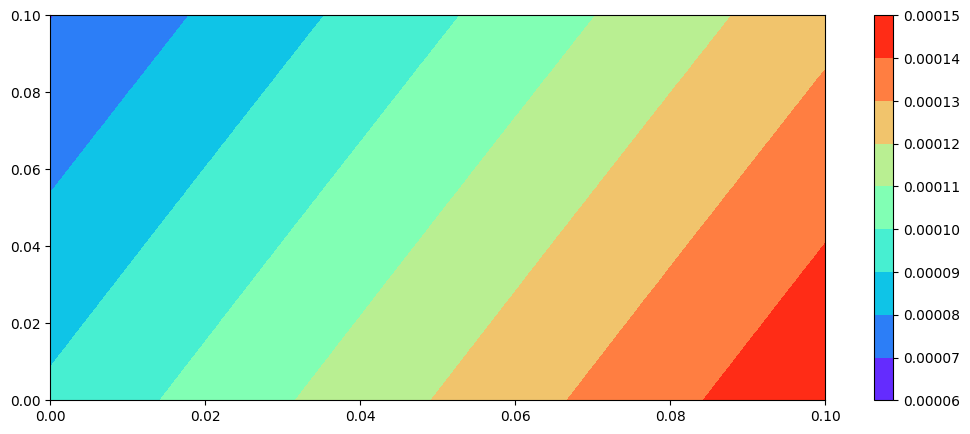

In [6]:
v_grid = plot_field(v,grid[0],grid[1])

In [12]:
from matplotlib import animation

def get_field_gif(field_grid,x_grid,y_grid,title,level_min = None,level_max =None):
  x_grid,y_grid = x_grid[:,:,0],y_grid[:,:,0]
  u_grid = field_grid
  fig,ax = plt.subplots()
  fig.set_figwidth(12.5)
  fig.set_figheight(5)

  ta = 240
  if level_min is None:
    level_min= torch.min(u_grid)
  if level_max is None:
    level_max=torch.max(u_grid)


  # level_min2,level_max2 = torch.min(vort),torch.max(vort)

  # CS = ax.contourf(x_grid,y_grid,vort[:,:,0], levels = np.linspace(level_min2, level_max2,10),cmap ='rainbow' )
  CS = ax.contourf(x_grid,y_grid,u_grid[:,:,0], levels = np.linspace(level_min, level_max,20),cmap = 'rainbow' )

  circ = plt.Circle((0,0),0.5)

  fig.colorbar(CS)
  def animateGraph(i):
      ax.clear()
      ax.set_title(f'{title} at Time {t[i]:.2f}')
      # CS = ax.contourf(x_grid,y_grid,vort[:,:,i], levels = np.linspace(level_min2, level_max2,10),cmap = 'rainbow' )
      CS = ax.contourf(x_grid,y_grid,u_grid[:,:,i], levels = np.linspace(level_min, level_max,20),cmap='rainbow' )
    #   ax.add_patch(circ)

  anim = animation.FuncAnimation(fig,animateGraph,ta,interval=50)
  anim.save(f'{title}.gif',writer= 'pillow')


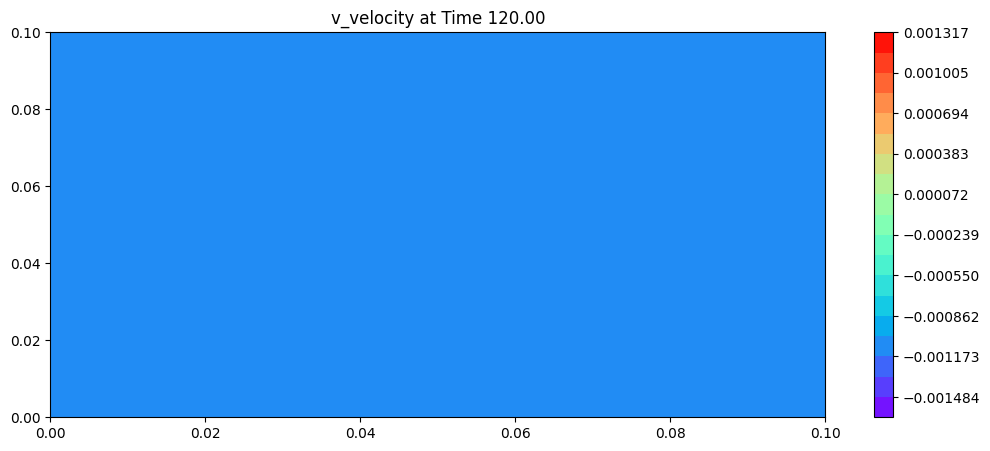

In [13]:
get_field_gif(v_grid,grid[0],grid[1],title = 'v_velocity')